# Sussex Quantum

Solves the time-dependent Schrödinger equation, $i \hbar \frac{d}{dt}| \psi(t) \rangle = H(t) | \psi(t)\rangle$:

```python
sesolve(H, psi0, t_list, e_ops=None, args=None, options=None)
```

- `H`: Hamiltonian (static or time-dependent)
- `psi0`: Initial state vector
- `t_list`: Array of time points for solution
- `e_ops`: Operators to monitor (expectation values)
- `args`: Extra parameters for time-dependent Hamiltonians
- `options`: Solver settings (tolerance, steps, etc.)

The `result` object
- `result.states`: List of quantum states at each time point (if stored)
- `result.expect`: Expecation values for each operator in `e_ops`
- `result.times`: Time points (same as input `t_list`)


The Hamiltonian is a matrix valued function. The Schrödinger equation is a system of ODE. This is, what the sesolver solves.

### Questions
- Why do we divide the spin operators by 2?
- Explain carefully every single line.

# Rabi Oscillations in Laboratory Frame

### System
- Electron 1/2 spin $s$
- Zeeman: $\hat{H}_{e,Z} = \omega_{e,Z} \hat{s}_z$, $\omega_{e,Z} ~ 2\pi(1..100 GHz)$
- Electron Spin Resonance (from rotating microwave field): $\hat{H}_{ESR} = \omega_{1,MW}(\cos(\omega_{MW} t) \hat{s}_x - sin(\omega_{MW} t) \hat{s}_{y})$
- Rabi frequency $\omega_{MW} << \omega_{e,Z}$
- Total Hamiltonian: $\hat{H}_{\text{Total}} = \hat{H}_{e,Z} + \hat{H}_{ESR}(t)$
- Schrödinger equation: $\psi'(t) = -i\hat{H}_{\text{Total}} \psi(t)$, $\hbar = 1$

### Setup
- Initial state: $s_z = 1/2$ eigenstate.
- Drive frequency: $\omega_{MW} = \omega_{e,Z}$ in resonance, or $\omega_{MW}$ detuned from $\omega_{e,Z}$ by up to a few $\omega_{1,MW}$
- Quantities to monitor: time dependence of expectation values of spin operators $\langle \hat{s}_x \rangle$, $\langle \hat{s}_y \rangle$, $\langle \hat{s}_z \rangle$

### Expected Results
- Resonant case $\omega_{MW} = \omega_{e,Z}$: Electron spin periodically oscillating between $s_z = +- 1/2$ eigenstate with frequency $\omega_{1,MW} / (2\pi)$
- Off-resonant case: Increasing detuning $|\omega_{MW} - \omega_{e,Z}|$ reduces visibiliy of Rabi oscillations (the spin never reaches the $s_z = -1/2$ state) and increases their frequency. Rabpi oscillations nearly disappear at large detuning $|\omega_{MW} - \omega_{e,Z}| >> \omega_{1,MW}$

### Implementation Notes
- Solver: `sesolve` is the best suited Qutip solver (numerical solver for systems of ODE, I think).
- Step size: To achieve convergence, the step size in teh solver should be smalelr than the smallest period of any physical process. In this case, the step should be smaller than ~$2\pi / \omega_{e,Z}$.
- Convergence test: The simplest test is to monitor that the wavefunction norm $|\psi(t)|^2$ is 1.
- Aliasing: Note that there will be fast ($\omega_{e,Z}$) and slow ($\omega_{1,MW}$) timescales in spin dynamics. Need to choose sufficiently small sampling step when plotting / tabulating to avoid spurious frequencies due to aliasing / undersampling.

### Remarks
- The solver integrates on the time grid we give (`times`)
- With `T_max = 100 ns` and `n_points = 5000`, the step is 0.02ns.
- 1 ns^-1 = 10^9 s^-1 = 1 GHz, so 2\pi \times 1.0 rad/ns = 2\pi \times 10^9 rad/s
- The period of oscillatio is T = 2\pi / \omega_e,Z = 1 ns
- Discuss how the units (rad/ns) correspond physically to energy in this \hbar = 1 system
- Discuss again the fastest vs slowest process in the system

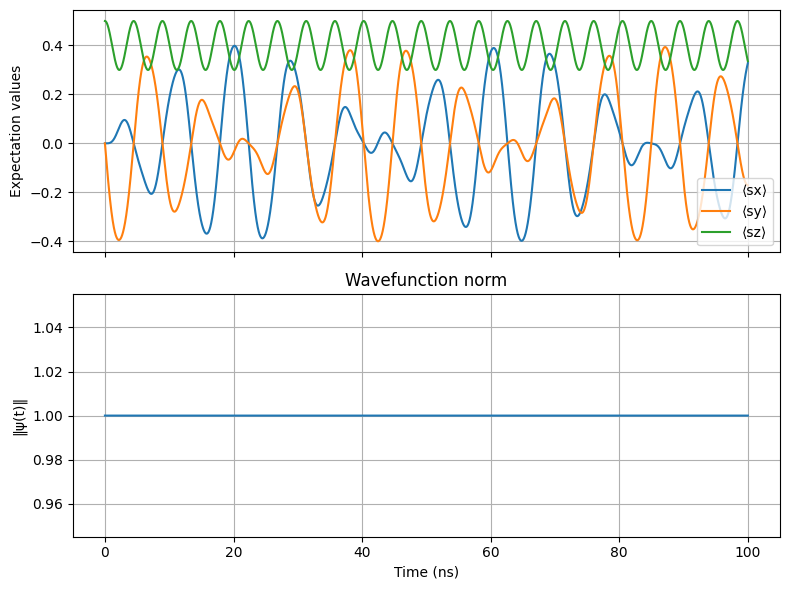

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters (units: rad/ns)
# Zeeman splitting is usually in 1..100 GHz range
omega_eZ = 2 * np.pi * 0.01  # 10 MHz (0.01 GHz) Zeeman splitting
omega_1MW = 2 * np.pi * 0.1  # 100 MHz (0.1 GHz) MW Rabi frequency
omega_MW = omega_eZ  # MW frequency on resonance

# Spin operators
sx = sigmax() / 2  # Sx operator
sy = sigmay() / 2  # Sy operator
sz = sigmaz() / 2  # Sz operator

# Static Zeeman Hamiltonian
H_zeeman = omega_eZ * sz

# Time-dependent ESR driving Hamiltonian
def c1(t, args):
    return omega_1MW * np.cos(omega_MW * t)

def c2(t, args):
    return -omega_1MW * np.sin(omega_MW * t)

# Total Hamiltonian
H_Total = [H_zeeman, [sx, c1], [sy, c2]]
#H_RWA = omega_1MW * sx

# Initial state (spin up along z)
psi0 = basis(2, 0) # |0> state

# Time grid
# - T_max / n_points = 0.02 ns time step
T_max = 100.0  # ns
n_points = 100000
times = np.linspace(0.0, T_max, n_points)

# Solve the Schrodinger equation
opts = {"store_states": True}
result = sesolve(H_Total, psi0, times, e_ops=[sx, sy, sz], options=opts)

# Expectation values
ex_sx, ex_sy, ex_sz = result.expect

# Norm of the wavefunction (should stay ~1)
norms = [state.norm() for state in result.states]

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axes[0].plot(times, ex_sx, label="⟨sx⟩")
axes[0].plot(times, ex_sy, label="⟨sy⟩")
axes[0].plot(times, ex_sz, label="⟨sz⟩")
axes[0].set_ylabel("Expectation values")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(times, norms)
axes[1].set_xlabel("Time (ns)")
axes[1].set_ylabel("‖ψ(t)‖")
axes[1].set_title("Wavefunction norm")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import qutip

# Set high precision for numerical stability
qutip.settings.atol = 1e-12 # x_{i+1} - x_i < atol
qutip.settings.rtol = 1e-10 # (x_{i+1} - x_i) / x_i < rtol

# Define fundamental constants
hbar = 1.0

In [ ]:
def setup_spin_system(omega_eZ, omega_1MW, omega_MW, detuning=0):
    """
    Setup the spin-1/2 system with ESR driving in laboratory frame

    Parameters:
    -----------
    omega_eZ : float
        Electron Zeeman frequency [rad/ns]
    omega_1MW : float
        Rabi frequency of the 1 MW microwave field [rad/ns]
    omega_MW : float
        Frequency of the microwave field [rad/ns]
    detuning : float
        Detuning of the microwave field from resonance [rad/ns]

    Returns:
    --------
    H0 : Qobj
        Static Hamiltonian of the system
    H1 : Qobj
        Driving Hamiltonian of the system
    args : dict
        Dictionary of parameters for time-dependent Hamiltonian
    """

    # Define spin operators for s=1/2
    sx = sigmax() / 2
    sy = sigmay() / 2
    sz = sigmaz() / 2

    # Static Hamiltonian (Zeeman term)
    H0 = omega_eZ * sz

    # Time-dependent ESR Hamiltonian
    # H_ESR(t) = ω₁[cos(ω_MW t)sx - sin(ω_MW t)sy]
    # We'll express this as two time-dependent terms
    
    # Define the time-dependent coefficients
    def H1_coeff_t(t, args):
        return args['omega_1MW'] * np.cos(args['omega_MW'] * t)
    
    def H2_coeff_t(t, args):
        return -args['omega_1MW'] * np.sin(args['omega_MW'] * t)
    
    # Time-dependent Hamiltonian components
    H1_terms = [
        [sx, H1_coeff_t],
        [sy, H2_coeff_t]
    ]

    # Arguments for time-dependent functions
    args = {
        'omega_1MW': omega_1MW,
        'omega_MW': omega_MW + detuning  # Apply detuning
    }
    
    H_total = [H0] + H1_terms

    return H_total, args, (sx, sy, sz)


def analytical_rabi_solution(omega_1MW, delta, times):
    """
    Analytical solution for Rabi oscillations
    
    Parameters:
    -----------
    omega_1MW : float
        Rabi frequency
    delta : float  
        Detuning Δ = omega_MW - omega_eZ
    times : array
        Time points
        
    Returns:
    --------
    P_up : array
        Probability of spin up
    P_down : array
        Probability of spin down  
    """
    
    # Effective Rabi frequency
    Omega_eff = np.sqrt(omega_1MW**2 + delta**2)
    
    # Population of spin down state
    P_down = (omega_1MW / Omega_eff)**2 * np.sin(Omega_eff * times / 2)**2
    
    # Population of spin up state  
    P_up = 1 - P_down
    
    return P_up, P_down

def compare_analytical_numerical(result, times, omega_1MW, delta):
    """
    Compare numerical results with analytical solution
    """
    
    # Numerical probabilities
    P_up_numerical = []
    for state in result.states:
        # Probability in |↑⟩ state
        prob_up = abs(state[0,0])**2  
        P_up_numerical.append(prob_up)
    
    # Analytical solution
    P_up_analytical, P_down_analytical = analytical_rabi_solution(
        omega_1MW, delta, times)
    
    return np.array(P_up_numerical), P_up_analytical


def simulate_rabi_oscillations(omega_eZ, omega_1MW, omega_MW, T_max, n_points, detuning=0, convergence_test=True):
    """
    Simulate Rabi oscillations of a spin-1/2 system under ESR driving

    Parameters:
    -----------
    omega_eZ : float
        Electron Zeeman frequency [rad/ns]
    omega_1MW : float
        Rabi frequency of the 1 MW microwave field [rad/ns]
    omega_MW : float
        Frequency of the microwave field [rad/ns]
    T_max : float
        Maximum time for simulation [ns]
    n_steps : int
        Number of time steps in the simulation
    detuning : float
        Detuning of the microwave field from resonance [rad/ns]
    convergence_test : bool
        Whether to perform a convergence test

    Returns:
    --------
    result : Result
        QuTiP simulation result
    times : array
        Time points
    expectation_values : dict
        Expectation values of spin operators
    """

    # Setup the system
    H_total, args, (sx, sy, sz) = setup_spin_system(omega_eZ, omega_1MW, omega_MW, detuning)

    # Initial state: spin up along z-axis
    psi0 = basis(2, 0)  # |0> state, |↑⟩ state

    # Time array with proper sampling
    # Critical: sampling rate > 2*omega_max (Nyquist criterion)
    omega_max = max(omega_eZ, omega_MW, omega_1MW)
    min_period = 2 * np.pi / omega_max
    
    # Ensure sufficient time resolution
    dt = T_max / n_points
    if dt > min_period / 10:
        print(f"Warning: Time step {dt:.2e} ns may be too large.")
        print(f"Recommended: dt < {min_period/10:.2e} ns")
    
    times = np.linspace(0, T_max, n_points)
    
    # Operators to monitor
    e_ops = [sx, sy, sz, sigmap(), sigmam()]
    
    # Solve Schrödinger equation
    result = sesolve(H_total, psi0, times, e_ops=e_ops, args=args, options=Options(store_states=True))
    
    # Convergence and norm test
    if convergence_test:
        norm_deviations = []
        for i, t in enumerate(times):
            state = result.states[i]
            norm = state.norm()
            norm_deviations.append(abs(norm - 1.0))
        
        max_norm_error = max(norm_deviations)
        print(f"Maximum norm deviation: {max_norm_error:.2e}")
        
        if max_norm_error > 1e-8:
            print("Warning: Significant norm deviation detected!")
    
    # Extract expectation values
    expectation_values = {
        'sx': result.expect[0],
        'sy': result.expect[1], 
        'sz': result.expect[2],
        'sp': result.expect[3],  # σ⁺ expectation
        'sm': result.expect[4]   # σ⁻ expectation
    }

    return result, times, expectation_values, (sx, sy, sz)

In [ ]:
"""
Complete simulation of Rabi oscillations with analysis
"""

# Physical parameters (in rad/ns)
omega_eZ = 2 * np.pi * 1.0  # 10 GHz Zeeman splitting
omega_1MW = 2 * np.pi * 0.1  # 100 MHz Rabi frequency  
omega_MW = omega_eZ          # On resonance

# Simulation parameters
T_max = 100.0  # 100 ns simulation time
n_points = 5000

print("Simulation Parameters:")
print(f"ω_eZ/2π = {omega_eZ/(2*np.pi):.1f} GHz")
print(f"ω_1MW/2π = {omega_1MW/(2*np.pi):.3f} GHz") 
print(f"ω_MW/2π = {omega_MW/(2*np.pi):.1f} GHz")
print(f"T_max = {T_max} ns")
print(f"Time step = {T_max/n_points:.3f} ns")

# Run simulation
result, times, expect, (sx, sy, sz) = simulate_rabi_oscillations(
    omega_eZ, omega_1MW, omega_MW, T_max, n_points)

# Compare with analytical solution
P_up_num, P_up_anal = compare_analytical_numerical(
    result, times, omega_1MW, delta=0)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Spin expectations
axes[0,0].plot(times, expect['sx'], label='⟨sx⟩')
axes[0,0].plot(times, expect['sy'], label='⟨sy⟩') 
axes[0,0].plot(times, expect['sz'], label='⟨sz⟩')
axes[0,0].set_xlabel('Time (ns)')
axes[0,0].set_ylabel('Expectation Value')
axes[0,0].set_title('Spin Operator Expectations')
axes[0,0].legend()
axes[0,0].grid(True)

# Population dynamics
axes[0,1].plot(times, P_up_num, 'b-', label='Numerical P(↑)')
axes[0,1].plot(times, P_up_anal, 'r--', label='Analytical P(↑)')
axes[0,1].set_xlabel('Time (ns)')
axes[0,1].set_ylabel('Population')
axes[0,1].set_title('Spin Up Population')
axes[0,1].legend()
axes[0,1].grid(True)

# Rabi oscillations in rotating frame
# Extract the envelope of Rabi oscillations
rabi_period = 2 * np.pi / omega_1MW
axes[1,0].plot(times, expect['sz'], 'b-')
axes[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1,0].set_xlabel('Time (ns)')
axes[1,0].set_ylabel('⟨sz⟩')
axes[1,0].set_title(f'Rabi Oscillations (Period = {rabi_period:.1f} ns)')
axes[1,0].grid(True)

# Phase space trajectory
axes[1,1].plot(expect['sx'], expect['sy'])
axes[1,1].set_xlabel('⟨sx⟩')
axes[1,1].set_ylabel('⟨sy⟩')
axes[1,1].set_title('Phase Space Trajectory')
axes[1,1].grid(True)
axes[1,1].axis('equal')

plt.tight_layout()
plt.show()

result, times, expect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import qutip

# Settings and constants
qutip.settings.atol = 1e-12
qutip.settings.rtol = 1e-10
hbar = 1.0

def setup_spin_system(omega_eZ, omega_1MW, omega_drive):
    """
    omega_drive: actual microwave drive angular frequency (rad / ns)
    """
    # spin-1/2 operators (note: sigmax()/2 gives s_x with eigenvalues ±1/2)
    sx = sigmax() / 2.0
    sy = sigmay() / 2.0
    sz = sigmaz() / 2.0

    # Static Zeeman
    H0 = omega_eZ * sz

    # time-dependent coefficients for lab-frame ESR field:
    def c1(t, args):
        return args['omega_1MW'] * np.cos(args['omega_drive'] * t)

    def c2(t, args):
        return -args['omega_1MW'] * np.sin(args['omega_drive'] * t)

    H_td = [[sx, c1], [sy, c2]]

    H_total = [H0] + H_td

    args = {'omega_1MW': omega_1MW, 'omega_drive': omega_drive}
    return H_total, args, (sx, sy, sz)


def analytical_rabi_solution(omega_1MW, delta, times):
    """Analytical populations for driven two-level system (starting in |↑>)"""
    Omega_eff = np.sqrt(omega_1MW**2 + delta**2)
    # population of down state
    P_down = (omega_1MW / Omega_eff)**2 * np.sin(Omega_eff * times / 2.0)**2
    P_up = 1.0 - P_down
    return P_up, P_down


def simulate_rabi_oscillations(omega_eZ, omega_1MW, omega_drive, T_max, n_points,
                              convergence_test=True, store_states=True):
    # Build Hamiltonian
    H_total, args, (sx, sy, sz) = setup_spin_system(omega_eZ, omega_1MW, omega_drive)

    # initial state |↑> = basis(2,0)
    psi0 = basis(2, 0)

    # Choose time array. Important: lab-frame has fast oscillation at ~omega_eZ.
    omega_max = max(abs(omega_eZ), abs(omega_drive), abs(omega_1MW))
    min_period = 2.0 * np.pi / omega_max
    dt = T_max / n_points
    if dt > min_period / 10:
        print(f"Warning: time-step dt={dt:.3e} ns may be too large to resolve carrier (recommend < {min_period/10:.3e})")

    times = np.linspace(0.0, T_max, n_points)

    # operators to compute expectations (use s_x, s_y, s_z)
    e_ops = [sx, sy, sz]

    opts = qutip.Options(store_states=True, atol=1e-12, rtol=1e-10)
    result = sesolve(H_total, psi0, times, e_ops=e_ops, args=args, options=opts)

    # convergence / norm test (only if states stored)
    if convergence_test and store_states:
        norms = [st.norm() for st in result.states]
        max_dev = max(abs(np.array(norms) - 1.0))
        print(f"Max norm deviation: {max_dev:.2e}")
        if max_dev > 1e-8:
            print("Warning: significant norm deviation!")

    expectations = {'sx': result.expect[0],
                    'sy': result.expect[1],
                    'sz': result.expect[2]}

    return result, times, expectations, (sx, sy, sz)


# --- Driver (example) ---
# Note: keep comments consistent with numerical values used below
omega_eZ = 2.0 * np.pi * 1.0      # 1.0 GHz carrier -> 2π rad/ns
omega_1MW = 2.0 * np.pi * 0.1     # 0.1 GHz = 100 MHz Rabi -> 2π*0.1 rad/ns
omega_drive = omega_eZ            # on resonance

T_max = 100.0   # ns
n_points = 5000

print("Params (in GHz):")
print(f"omega_eZ/(2π) = {omega_eZ/(2*np.pi):.3f} GHz")
print(f"omega_1MW/(2π) = {omega_1MW/(2*np.pi):.3f} GHz")
print(f"omega_drive/(2π) = {omega_drive/(2*np.pi):.3f} GHz")
print(f"T_max = {T_max} ns, n_points = {n_points}, dt = {T_max/n_points:.4f} ns")

result, times, expect, (sx, sy, sz) = simulate_rabi_oscillations(
    omega_eZ, omega_1MW, omega_drive, T_max, n_points)

# Numerical P_up from <sz>: P_up = 0.5 + <sz>
P_up_num = 0.5 + np.array(expect['sz'])

# Analytical using correct delta = omega_drive - omega_eZ
delta = omega_drive - omega_eZ
P_up_anal, _ = analytical_rabi_solution(omega_1MW, delta, times)

# --- plotting ---
plt.figure(figsize=(10,5))
plt.plot(times, P_up_num, label='Numerical P(↑)')
plt.plot(times, P_up_anal, '--', label='Analytical P(↑)')
plt.xlabel('time (ns)')
plt.ylabel('P(↑)')
plt.legend()
plt.grid(True)
plt.show()
